In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has three classes: whether stock will go up, down or stay constant X days after last input.

Story: Investor observes stock for 60 days. Then decides whether buy some stocks and sell it after 10 days. Therefore input consist of stock prices from day 1st to 60th, output is:
* -1 if price will go down by more than 1%, 
* 0 if price will not go up or down by more than 1% 
* 1 if price will go up by more than 1%

Relative change output is calculated using the following formula: (opening_price_on_buyout_day -closing_price_on_last_day_of_observation) / opening_price_on_buyout_day * 100%

Based on percentage value from formula above, label will be calculated.

In [1]:
OBSERVATION_TIME = 60
PREDICTION_AFTER_DAYS = 10
PERCENTAGE_THRESHOLD = 0.5
EPOCHS = 2000
TEST_SIZE = 0.40
RANDOM_SPLIT = False

In [2]:
import pandas as pd

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [3]:
def percentage_to_label(percentage_value):
    return -1 if percentage_value < -PERCENTAGE_THRESHOLD else 0 if percentage_value <= PERCENTAGE_THRESHOLD else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0].head(5)

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


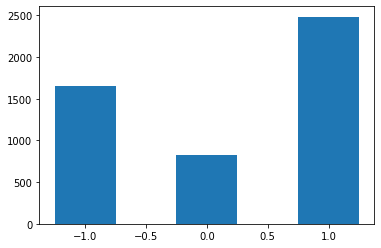

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results, bins=[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25])
plt.show()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [6]:
import numpy as np
from keras.utils import to_categorical

def categorical_labels(label_array):
    return to_categorical(list(map(lambda x: x + 1, label_array)))

categorical_labels(observation_results)

Using TensorFlow backend.


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [7]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (60, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 16)            336       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 8)             520       
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 8)            

In [8]:
from keras.optimizers import Nadam

model.compile(optimizer=Nadam(lr=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(categorical_labels(observation_results))

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2976, 60, 5), (2976, 3), (1984, 60, 5), (1984, 3))

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [reduce_lr, checkpointer])

Train on 2976 samples, validate on 1984 samples
Epoch 1/2000
2976/2976 [==============================] - 1s 307us/step - loss: 1.1903 - accuracy: 0.3810 - val_loss: 3.1304 - val_accuracy: 0.5192

Epoch 00001: val_loss improved from inf to 3.13036, saving model to model.hdf5
Epoch 2/2000
2304/2976 [======================>.......] - ETA: 0s - loss: 1.0744 - accuracy: 0.4379

/Users/mateusz.kuzmik/university/trading-xai/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2976/2976 [==============================] - 0s 92us/step - loss: 1.0631 - accuracy: 0.4476 - val_loss: 5.6301 - val_accuracy: 0.4929

Epoch 00002: val_loss did not improve from 3.13036
Epoch 3/2000
2976/2976 [==============================] - 0s 89us/step - loss: 1.0317 - accuracy: 0.4503 - val_loss: 3.1900 - val_accuracy: 0.2656

Epoch 00003: val_loss did not improve from 3.13036
Epoch 4/2000
2976/2976 [==============================] - 0s 84us/step - loss: 1.0295 - accuracy: 0.4432 - val_loss: 7.5506 - val_accuracy: 0.2656

Epoch 00004: val_loss did not improve from 3.13036
Epoch 5/2000
2976/2976 [==============================] - 0s 81us/step - loss: 1.0159 - accuracy: 0.4654 - val_loss: 4.5549 - val_accuracy: 0.2656

Epoch 00005: val_loss did not improve from 3.13036
Epoch 6/2000
2976/2976 [==============================] - 0s 80us/step - loss: 1.0142 - accuracy: 0.4661 - val_loss: 1.3031 - val_accuracy: 0.2656

Epoch 00006: val_loss improved from 3.13036 to 1.30306, saving model 

2976/2976 [==============================] - 0s 79us/step - loss: 0.9772 - accuracy: 0.4882 - val_loss: 1.1574 - val_accuracy: 0.5192

Epoch 00042: val_loss did not improve from 1.02439
Epoch 43/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.9792 - accuracy: 0.4943 - val_loss: 1.2351 - val_accuracy: 0.3100

Epoch 00043: val_loss did not improve from 1.02439
Epoch 44/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9807 - accuracy: 0.4782 - val_loss: 1.0920 - val_accuracy: 0.5096

Epoch 00044: val_loss did not improve from 1.02439
Epoch 45/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.9774 - accuracy: 0.4923 - val_loss: 1.2409 - val_accuracy: 0.3886

Epoch 00045: val_loss did not improve from 1.02439
Epoch 46/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9747 - accuracy: 0.4980 - val_loss: 1.2099 - val_accuracy: 0.2802

Epoch 00046: val_loss did not improve from 1.02439
Epoch 47/2000


2976/2976 [==============================] - 0s 78us/step - loss: 0.9705 - accuracy: 0.5060 - val_loss: 2.3173 - val_accuracy: 0.4612

Epoch 00083: val_loss did not improve from 1.02439
Epoch 84/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9645 - accuracy: 0.5101 - val_loss: 3.1265 - val_accuracy: 0.5192

Epoch 00084: val_loss did not improve from 1.02439
Epoch 85/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.9662 - accuracy: 0.5144 - val_loss: 1.1164 - val_accuracy: 0.5192

Epoch 00085: val_loss did not improve from 1.02439
Epoch 86/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.9600 - accuracy: 0.5118 - val_loss: 2.1068 - val_accuracy: 0.5156

Epoch 00086: val_loss did not improve from 1.02439
Epoch 87/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9713 - accuracy: 0.5017 - val_loss: 2.1682 - val_accuracy: 0.2656

Epoch 00087: val_loss did not improve from 1.02439
Epoch 88/2000


2976/2976 [==============================] - 0s 83us/step - loss: 0.9464 - accuracy: 0.5323 - val_loss: 1.9862 - val_accuracy: 0.2923

Epoch 00124: val_loss did not improve from 1.02439
Epoch 125/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9470 - accuracy: 0.5393 - val_loss: 1.4460 - val_accuracy: 0.2984

Epoch 00125: val_loss did not improve from 1.02439
Epoch 126/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9495 - accuracy: 0.5323 - val_loss: 1.5323 - val_accuracy: 0.3120

Epoch 00126: val_loss did not improve from 1.02439
Epoch 127/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9433 - accuracy: 0.5423 - val_loss: 3.8067 - val_accuracy: 0.2495

Epoch 00127: val_loss did not improve from 1.02439
Epoch 128/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9476 - accuracy: 0.5383 - val_loss: 1.1625 - val_accuracy: 0.3014

Epoch 00128: val_loss did not improve from 1.02439
Epoch 129/

2976/2976 [==============================] - 0s 79us/step - loss: 0.9190 - accuracy: 0.5672 - val_loss: 2.8871 - val_accuracy: 0.2656

Epoch 00165: val_loss did not improve from 1.02439
Epoch 166/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9163 - accuracy: 0.5618 - val_loss: 2.0557 - val_accuracy: 0.3382

Epoch 00166: val_loss did not improve from 1.02439
Epoch 167/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.9049 - accuracy: 0.5766 - val_loss: 1.5719 - val_accuracy: 0.2818

Epoch 00167: val_loss did not improve from 1.02439
Epoch 168/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9122 - accuracy: 0.5746 - val_loss: 1.1461 - val_accuracy: 0.5030

Epoch 00168: val_loss did not improve from 1.02439
Epoch 169/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.9182 - accuracy: 0.5689 - val_loss: 1.8934 - val_accuracy: 0.3085

Epoch 00169: val_loss did not improve from 1.02439
Epoch 170/

2976/2976 [==============================] - 0s 82us/step - loss: 0.8850 - accuracy: 0.5890 - val_loss: 1.7139 - val_accuracy: 0.4738

Epoch 00206: val_loss did not improve from 1.02439
Epoch 207/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.8806 - accuracy: 0.5894 - val_loss: 1.4193 - val_accuracy: 0.4682

Epoch 00207: val_loss did not improve from 1.02439
Epoch 208/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.8847 - accuracy: 0.5971 - val_loss: 1.8174 - val_accuracy: 0.3367

Epoch 00208: val_loss did not improve from 1.02439
Epoch 209/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.8752 - accuracy: 0.5951 - val_loss: 2.9364 - val_accuracy: 0.2611

Epoch 00209: val_loss did not improve from 1.02439
Epoch 210/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.8814 - accuracy: 0.5974 - val_loss: 2.8047 - val_accuracy: 0.2697

Epoch 00210: val_loss did not improve from 1.02439
Epoch 211/

2976/2976 [==============================] - 0s 77us/step - loss: 0.8480 - accuracy: 0.6132 - val_loss: 1.8578 - val_accuracy: 0.3478

Epoch 00247: val_loss did not improve from 1.02439
Epoch 248/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.8508 - accuracy: 0.6196 - val_loss: 1.3017 - val_accuracy: 0.4526

Epoch 00248: val_loss did not improve from 1.02439
Epoch 249/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.8522 - accuracy: 0.6042 - val_loss: 2.5326 - val_accuracy: 0.5207

Epoch 00249: val_loss did not improve from 1.02439
Epoch 250/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.8566 - accuracy: 0.6166 - val_loss: 2.0647 - val_accuracy: 0.4879

Epoch 00250: val_loss did not improve from 1.02439
Epoch 251/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.8433 - accuracy: 0.6149 - val_loss: 3.7664 - val_accuracy: 0.5071

Epoch 00251: val_loss did not improve from 1.02439
Epoch 252/

2976/2976 [==============================] - 0s 80us/step - loss: 0.8128 - accuracy: 0.6495 - val_loss: 3.9132 - val_accuracy: 0.2757

Epoch 00288: val_loss did not improve from 1.02439
Epoch 289/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8161 - accuracy: 0.6384 - val_loss: 1.6499 - val_accuracy: 0.3463

Epoch 00289: val_loss did not improve from 1.02439
Epoch 290/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8282 - accuracy: 0.6358 - val_loss: 1.7068 - val_accuracy: 0.3952

Epoch 00290: val_loss did not improve from 1.02439
Epoch 291/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8200 - accuracy: 0.6374 - val_loss: 3.0922 - val_accuracy: 0.2959

Epoch 00291: val_loss did not improve from 1.02439
Epoch 292/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.8141 - accuracy: 0.6442 - val_loss: 4.0963 - val_accuracy: 0.3548

Epoch 00292: val_loss did not improve from 1.02439
Epoch 293/

2976/2976 [==============================] - 0s 81us/step - loss: 0.7828 - accuracy: 0.6566 - val_loss: 2.1023 - val_accuracy: 0.4037

Epoch 00329: val_loss did not improve from 1.02439
Epoch 330/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.7805 - accuracy: 0.6562 - val_loss: 2.3284 - val_accuracy: 0.4103

Epoch 00330: val_loss did not improve from 1.02439
Epoch 331/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.7717 - accuracy: 0.6731 - val_loss: 2.5258 - val_accuracy: 0.2984

Epoch 00331: val_loss did not improve from 1.02439
Epoch 332/2000
2976/2976 [==============================] - 0s 81us/step - loss: 0.7713 - accuracy: 0.6640 - val_loss: 1.6969 - val_accuracy: 0.4078

Epoch 00332: val_loss did not improve from 1.02439
Epoch 333/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.7948 - accuracy: 0.6546 - val_loss: 3.8400 - val_accuracy: 0.2898

Epoch 00333: val_loss did not improve from 1.02439
Epoch 334/

2976/2976 [==============================] - 0s 80us/step - loss: 0.7578 - accuracy: 0.6717 - val_loss: 4.8024 - val_accuracy: 0.4950

Epoch 00370: val_loss did not improve from 1.02439
Epoch 371/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.7651 - accuracy: 0.6757 - val_loss: 3.7661 - val_accuracy: 0.3009

Epoch 00371: val_loss did not improve from 1.02439
Epoch 372/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.7608 - accuracy: 0.6660 - val_loss: 5.9346 - val_accuracy: 0.2712

Epoch 00372: val_loss did not improve from 1.02439
Epoch 373/2000
2976/2976 [==============================] - 0s 80us/step - loss: 0.7624 - accuracy: 0.6610 - val_loss: 1.9809 - val_accuracy: 0.2903

Epoch 00373: val_loss did not improve from 1.02439
Epoch 374/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.7499 - accuracy: 0.6761 - val_loss: 3.2757 - val_accuracy: 0.3191

Epoch 00374: val_loss did not improve from 1.02439
Epoch 375/

2976/2976 [==============================] - 0s 79us/step - loss: 0.7303 - accuracy: 0.6872 - val_loss: 2.9459 - val_accuracy: 0.3261

Epoch 00411: val_loss did not improve from 1.02439
Epoch 412/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.7494 - accuracy: 0.6670 - val_loss: 7.4270 - val_accuracy: 0.2243

Epoch 00412: val_loss did not improve from 1.02439
Epoch 413/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.7435 - accuracy: 0.6902 - val_loss: 3.6394 - val_accuracy: 0.2989

Epoch 00413: val_loss did not improve from 1.02439
Epoch 414/2000
2976/2976 [==============================] - 0s 79us/step - loss: 0.7289 - accuracy: 0.6878 - val_loss: 7.6396 - val_accuracy: 0.2656

Epoch 00414: val_loss did not improve from 1.02439
Epoch 415/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7454 - accuracy: 0.6791 - val_loss: 4.6078 - val_accuracy: 0.2460

Epoch 00415: val_loss did not improve from 1.02439
Epoch 416/

2976/2976 [==============================] - 0s 76us/step - loss: 0.7078 - accuracy: 0.7019 - val_loss: 2.5143 - val_accuracy: 0.3659

Epoch 00452: val_loss did not improve from 1.02439
Epoch 453/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7097 - accuracy: 0.7006 - val_loss: 3.1665 - val_accuracy: 0.4531

Epoch 00453: val_loss did not improve from 1.02439
Epoch 454/2000
2976/2976 [==============================] - 0s 75us/step - loss: 0.7172 - accuracy: 0.6909 - val_loss: 2.6529 - val_accuracy: 0.2964

Epoch 00454: val_loss did not improve from 1.02439
Epoch 455/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7455 - accuracy: 0.6875 - val_loss: 5.5499 - val_accuracy: 0.2686

Epoch 00455: val_loss did not improve from 1.02439
Epoch 456/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7066 - accuracy: 0.6972 - val_loss: 4.0698 - val_accuracy: 0.2863

Epoch 00456: val_loss did not improve from 1.02439
Epoch 457/

2976/2976 [==============================] - 0s 77us/step - loss: 0.7126 - accuracy: 0.6932 - val_loss: 3.9532 - val_accuracy: 0.3322

Epoch 00493: val_loss did not improve from 1.02439
Epoch 494/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.7016 - accuracy: 0.7063 - val_loss: 2.2051 - val_accuracy: 0.3609

Epoch 00494: val_loss did not improve from 1.02439
Epoch 495/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7006 - accuracy: 0.7046 - val_loss: 2.3399 - val_accuracy: 0.3453

Epoch 00495: val_loss did not improve from 1.02439
Epoch 496/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.7064 - accuracy: 0.6993 - val_loss: 3.0685 - val_accuracy: 0.4516

Epoch 00496: val_loss did not improve from 1.02439
Epoch 497/2000
2976/2976 [==============================] - 0s 78us/step - loss: 0.7036 - accuracy: 0.7087 - val_loss: 4.6101 - val_accuracy: 0.3266

Epoch 00497: val_loss did not improve from 1.02439
Epoch 498/

2976/2976 [==============================] - 0s 83us/step - loss: 0.6852 - accuracy: 0.7087 - val_loss: 6.0428 - val_accuracy: 0.2777

Epoch 00534: val_loss did not improve from 1.02439
Epoch 535/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.6815 - accuracy: 0.7087 - val_loss: 2.9752 - val_accuracy: 0.3564

Epoch 00535: val_loss did not improve from 1.02439
Epoch 536/2000
2976/2976 [==============================] - 0s 76us/step - loss: 0.6869 - accuracy: 0.7090 - val_loss: 2.6722 - val_accuracy: 0.3473

Epoch 00536: val_loss did not improve from 1.02439
Epoch 537/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.6680 - accuracy: 0.7325 - val_loss: 4.0302 - val_accuracy: 0.3392

Epoch 00537: val_loss did not improve from 1.02439
Epoch 538/2000
2976/2976 [==============================] - 0s 77us/step - loss: 0.6854 - accuracy: 0.7046 - val_loss: 3.2992 - val_accuracy: 0.3281

Epoch 00538: val_loss did not improve from 1.02439
Epoch 539/

In [ ]:
history_dict = history.history
history_dict.keys()

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(2, 2, 1)
plt.title('loss')
plt.plot(history_dict['loss'])
plt.subplot(2, 2, 2)
plt.title('val_loss')
plt.plot(history_dict['val_loss'])
plt.subplot(2, 2, 3)
plt.title('accuracy')
plt.plot(history_dict['accuracy'])
plt.subplot(2, 2, 4)
plt.title('val_accuracy')
plt.plot(history_dict['val_accuracy'])

plt.show()

In [ ]:
labels = np.argmax(Y_test, axis=1)

plt.hist(labels)

In [ ]:
preds = model.predict(np.array(X_test))

plt.hist(np.argmax(preds, axis=1))

In [ ]:
pred_down_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 1])
print('pred_down_while_steady: ', pred_down_while_steady)

pred_steady_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 1])
print('pred_steady_while_steady: ', pred_steady_while_steady)

pred_up_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 1])
print('pred_up_while_steady: ', pred_up_while_steady)

In [ ]:
pred_down_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 0])
print('pred_down_while_down: ', pred_down_while_down)

pred_steady_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 0])
print('pred_steady_while_down: ', pred_steady_while_down)

pred_up_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 0])
print('pred_up_while_down: ', pred_up_while_down)

In [ ]:
pred_down_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 2])
print('pred_down_while_up: ', pred_down_while_up)

pred_steady_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 2])
print('pred_steady_while_up: ', pred_steady_while_up)

pred_up_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 2])
print('pred_up_while_up: ', pred_up_while_up)